In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [2]:
train_data = pd.read_feather('../data/train_data.ftr')

In [3]:
train_data.shape

(5531451, 191)

In [4]:
# list of feature columns
feature_cols = [col for col in train_data.columns if col not in ['customer_ID','S_2', 'target']]
# list of categorical columns
cat_cols = [col for col in feature_cols if train_data[col].dtype == 'object']
# list of numerical columns
num_cols = [col for col in feature_cols if train_data[col].dtype != 'object']


In [5]:
pd.DataFrame(train_data[feature_cols].dtypes, columns=['dtype']).to_clipboard()

In [6]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [7]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

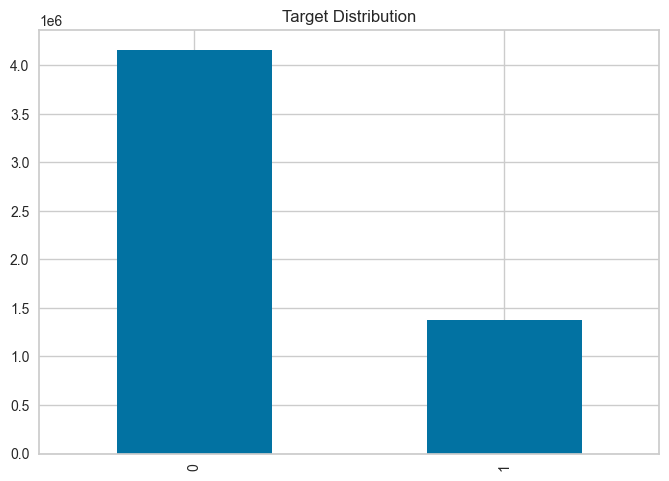

In [8]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [9]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [10]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]

<AxesSubplot: title={'center': 'Number of rows per customer'}, ylabel='Frequency'>

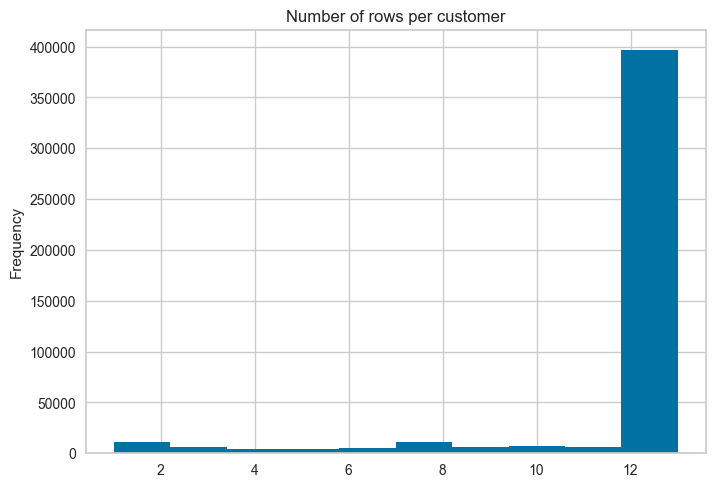

In [11]:
# calculate and plot the number of rows of data for each customer
customer_count = train_data['customer_ID'].value_counts()
customer_count.plot(kind='hist', title='Number of rows per customer')


In [12]:
customer_count.max()

13

### Pycaret

In [13]:
# pick random sample of customer_IDs from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 10000, replace=False)

In [14]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]


In [15]:
train_rndm_sample.shape

(124538, 194)

In [16]:
# customer_IDs that are not in the random sample for the training data
customer_ID_not_train = list(set(train_data['customer_ID']).difference(set(customer_ID_rand)))

# pick random sample of customer_IDs from customer_ID_not_train
customer_ID_test_rnd = np.random.choice(customer_ID_not_train, 10000, replace=False)

# test data based on the random sample of customer_IDs
test_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_test_rnd)].sort_values(by=['customer_ID', 'S_2'])

In [17]:
test_rndm_sample.shape

(120512, 194)

In [ ]:
test_rndm_sample.to_csv('../data/test_data-amex_05_12_2023.csv', index=False)

In [37]:
# drop customer_ID and S_2 from train and test data
train_rndm_sample.drop(['customer_ID', 'S_2'], axis=1, inplace=True)
test_rndm_sample.drop(['customer_ID', 'S_2'], axis=1, inplace=True)

0    0.767212
1    0.232788
Name: target, dtype: float64


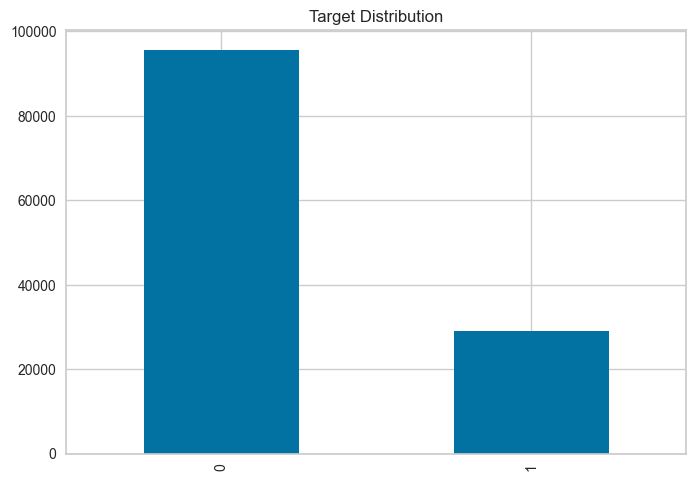

In [38]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

In [39]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fix_imbalance=True )

In [40]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [42]:
best = s.compare_models(include=['knn', 'xgboost', 'catboost', 'lightgbm', 'dummy'])

In [43]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

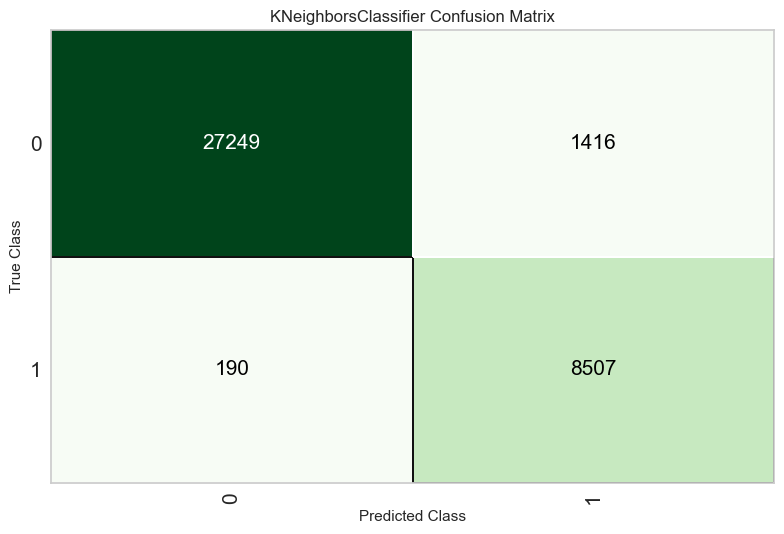

In [44]:
s.plot_model(best, plot = 'confusion_matrix')

In [45]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9510,0.9902,0.9763,0.8396,0.9028,0.8703,0.8748,5.129
catboost,CatBoost Classifier,0.9417,0.9815,0.8694,0.8789,0.8741,0.8362,0.8362,13.132
xgboost,Extreme Gradient Boosting,0.9241,0.9738,0.8381,0.8363,0.8372,0.7877,0.7877,19.351
lightgbm,Light Gradient Boosting Machine,0.8990,0.9576,0.8072,0.7700,0.7881,0.7218,0.7222,1.645
dummy,Dummy Classifier,0.7672,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.324


In [46]:
# Resutls on the test set based on the best model

predictions_test = s.predict_model(best, data=test_rndm_sample)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8013,0.8546,0.7995,0.5721,0.6669,0.5308,0.5459


### LSTM model

In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import AUC


In [100]:
# Sort the data by customer and then by month
df = train_rndm_sample.copy()
df = df.groupby('customer_ID').filter(lambda x: len(x) <= 13)
# Sort the data by customer and then by date
# Assuming the date column is named 'date'
df['date'] = pd.to_datetime(df['S_2'])
df.drop(['S_2','Month', 'Day', 'Year'], axis=1, inplace=True)
df.sort_values(['customer_ID', 'date'], inplace=True)
categorical_columns = df.select_dtypes(include=['category']).columns
categorical_columns
df = pd.get_dummies(df, columns=categorical_columns)

In [101]:
len([x for x in df.columns if x not in ['customer_ID', 'target', 'date']])

223

In [102]:
def get_max_len_and_index_map(df):
    unique_customers = df['customer_ID'].unique()
    customer_index_map = {customer: idx for idx, customer in enumerate(unique_customers)}
    max_len = 0

    for customer in tqdm(unique_customers, desc='Getting max length', total=len(unique_customers)):
        customer_data = df[df['customer_ID'] == customer]
        max_len = max(max_len, len(customer_data))

    return max_len, customer_index_map

In [125]:
def reshape_data(df, max_len, customer_index_map):
    num_customers = len(customer_index_map)
    num_features = df.drop(['customer_ID', 'date', 'target'], axis=1).shape[1]
    X = np.zeros((num_customers, max_len - 12, 12, num_features))
    y = np.zeros((num_customers, max_len - 12))
    mask = np.zeros((num_customers, max_len - 12))


    df['customer_index'] = df['customer_ID'].map(customer_index_map)
    customer_data = df.groupby('customer_index').apply(
        lambda x: x.drop(['customer_ID', 'date', 'target', 'customer_index'], axis=1).values  # Exclude 'customer_index' now
    )

    for idx, data in customer_data.items():
        num_rows = data.shape[0] - 12 if data.shape[0] > 12 else 0
        if num_rows > 0:
            try:
                X[idx, :num_rows] = np.stack([data[i:i+12] for i in range(num_rows)], axis=0)
                y[idx, :num_rows] = data[12:, -1]
                mask[idx, :num_rows] = True
            except ValueError as e:
                print(f"Error occurred at customer index {idx} with {num_rows} rows of data")
                print(f"Shapes of data segments: {[data[i:i+12].shape for i in range(num_rows)]}")
                print(f"Shape of X at index {idx}: {X[idx, :num_rows].shape}")
                raise e
        elif data.shape[0] > 0:  # handle the case where a customer has less than 12 months of data
            X[idx, 0, :data.shape[0]] = data
            mask[idx, 0, :data.shape[0]] = True

    return X.reshape(-1, 12, num_features), y.reshape(-1), mask.reshape(-1)


In [126]:
max_len, customer_index_map = get_max_len_and_index_map(df)


Getting max length: 100%|██████████| 9888/9888 [00:34<00:00, 289.52it/s]


In [127]:
X, y, mask = reshape_data(df, max_len, customer_index_map)

Error occurred at customer index 0 with 1 rows of data
Shapes of data segments: [(12, 223)]
Shape of X at index 0: (1, 12, 224)


ValueError: could not broadcast input array from shape (1,12,223) into shape (1,12,224)

In [88]:
X.shape

(9888, 12, 223)

In [89]:
# Normalizing the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
mask_torch = torch.tensor(mask, dtype=torch.bool)

# Train-test split
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(X, y, mask_torch, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train, mask_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test, mask_test)

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [90]:
import torch.nn as nn

class CreditDefaultNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CreditDefaultNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  

        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [93]:
# Define the model
import torch
device = torch.device("mps")

model = CreditDefaultNet(input_size=223, hidden_size=64, num_layers=2, output_size=1).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (inputs, labels, mask) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        outputs = model(inputs)

        # Print shapes
        print("Outputs shape:", outputs.shape)
        print("Labels shape:", labels.shape)
        print("Mask shape:", mask.shape)

        loss = criterion(outputs[mask], labels[mask])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')



Outputs shape: torch.Size([32, 1])
Labels shape: torch.Size([32])
Mask shape: torch.Size([32, 12, 223])


IndexError: too many indices for tensor of dimension 2

In [118]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [119]:
X

array([[[1.00292969e+00, 5.08789062e-01, 4.06799316e-02, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.00781250e+00, 4.77050781e-01, 3.21350098e-02, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.00195312e+00, 4.50439453e-01, 3.19824219e-02, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        ...,
        [1.00488281e+00, 4.44335938e-01, 1.02111816e-01, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.00781250e+00, 4.48974609e-01, 1.01074219e-01, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [1.00585938e+00, 8.11100006e-04, 9.24682617e-02, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00]],

       [[9.94628906e-01, 3.38554382e-03, 1.83105469e-02, ...,
         0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00292969e+00, 6.75201416e-03, 2.12402344e-02, ...,
         0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00781250e+00, 

In [120]:
# Assuming you have defined an optimizer and criterion (loss function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Convert to tensors
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)
mask_train_tensor = torch.tensor(mask_train).to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Apply the mask to the outputs
    outputs_masked = outputs[mask_train_tensor]
    y_train_masked = y_train_tensor[mask_train_tensor]
    
    # Calculate loss
    loss = criterion(outputs_masked, y_train_masked)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))


ValueError: Input contains NaN.